In [99]:
from sys import platform as sys_pf
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
# ! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
# import nibabel as nib
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random

folder = 'data/'

def fft_2d():
    for item in os.listdir(folder):
        if item.endswith(".gz"):
            reader = sitk.ImageFileReader()
            reader.SetImageIO("NiftiImageIO")
            reader.SetFileName(folder + item)
            image = reader.Execute()

            # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

            # convert image into np array & perform fft
            img = sitk.GetArrayFromImage(image)
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            magnitude_spectrum = 20 * np.log(np.abs(fshift))

            # display the slice & K-Space
            plt.subplot(121), plt.imshow(img, cmap='gray')
            plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
            plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
            plt.title('K-Space'), plt.xticks([]), plt.yticks([])
            plt.show()



/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/eggfooyang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/eggfooyang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel/kerne

690


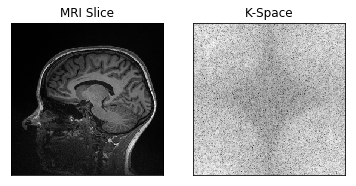

In [2]:
def fft_back(img, mx, mn, flp):
    # Produce the image given the original maximum, minimum values
    back_fft = np.fft.fftn(img)
    img_min = np.amin(img)
    img_max = np.amax(img)
    back_fft = ((back_fft - img_min)/img_max)*(mx-mn)
    back_fft = back_fft.astype(int)
    
    if flp==True:
        back_fft = np.flip(back_fft, 0)
        back_fft = np.flip(back_fft, 1)
        back_fft = np.flip(back_fft, 2)
    return back_fft

for item in os.listdir(folder):
    if item.endswith(".nii"):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(folder + item)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # print(img.shape)
        orig_slice = img[100]
        
        # FFT in 3d
        v = np.fft.fftn(img)
        new_slice = v[100]

        magnitude_spectrum = 20 * np.log(np.abs(new_slice))
        back_spectrum = np.fft.fftn(magnitude_spectrum)
        back_img = 20 * np.log(np.abs(back_spectrum))

        back_max = np.amax(back_spectrum)
        back_min = np.amin(back_spectrum)

        back_fft = np.fft.fftn(v)
        back_slice = back_fft[100]

        print(np.amax(orig_slice))

        # plt.subplot(121), plt.imshow(back_img, cmap='gray')
        # plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
        plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('K-Space'), plt.xticks([]), plt.yticks([])

In [12]:
len(img)

176

/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


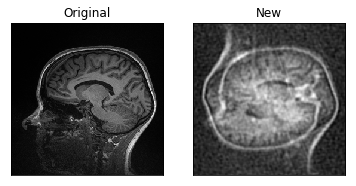

In [57]:
class mri(object):
    def __init__(self, img):
        self.original = img
        self.ks = np.fft.fftn(img)
        self.max = np.amax(img)
        self.min = np.amin(img)
        self.ks_vis = (self.ks-np.amin(self.ks))*np.amax(self.original)/(np.amax(self.ks)-np.amin(self.ks))
        self.ks_vis = self.ks_vis.astype(int)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
        
    def fft_back(self, kspace, flp):
        # Produce the image given the kspace
        back_fft = np.fft.fftn(kspace)
        mx = np.amax(kspace)
        mn = np.amin(kspace)
        back_fft = ((back_fft - self.min)/self.max)*(mx-mn)
        back_fft = back_fft.astype(int)
        if flp==True:
            back_fft = np.flip(back_fft, 0)
            back_fft = np.flip(back_fft, 1)
            back_fft = np.flip(back_fft, 2)
        return back_fft
    
    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=100)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks_vis[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=100)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])
mri1 = mri(img)
ks = mri1.ks_vis
new_3d_ks = ks.copy()

# slc = ks[100]
# rot_slice = mri1.rotate('k', 100, 20)
# tran_slice = mri1.translate('k',100,[30,0])

# new_3d_ks[100] = rot_slice
# mri1.show_slice(tran_slice, 30, 'k')

new_3d_vs = mri1.fft_back(new_3d_ks, False)

mri1.show_slice(new_3d_vs[100], 100, 'v')

# steps-
# transform to kspace
# rotate one kspace slice
# replace rotated slice into original kspace



/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


(Text(0.5,1,'K-Space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

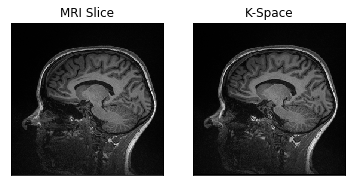

In [70]:
back_fft = np.fft.fftn(v)
back_min = np.amin(back_fft)
back_max = np.amax(back_fft)
back_fft = ((back_fft - back_min)/back_max)*878
back_fft = back_fft.astype(int)

back_fft = fft_back(v, np.amax(img), np.amin(img), True)
plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(back_fft[100], cmap='gray')
plt.title('K-Space'), plt.xticks([]), plt.yticks([])

/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


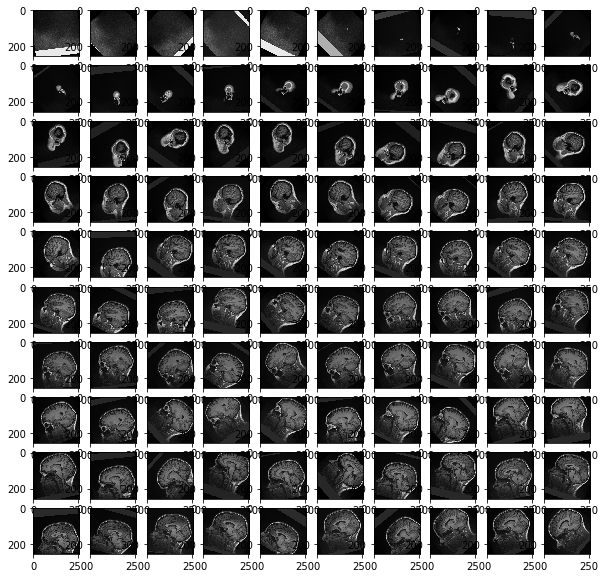

In [114]:
back_fft2 = v.copy()
back_real = back_fft2.real
back_imag = back_fft2.imag

plt.figure(figsize= (10,10))
for i in range(1, 101):
    trans = random.randint(-50,50)
    rot = random.randint(-50,50)
    back_slice_r = back_real[i].copy()
    back_slice_i = back_imag[i].copy()
    img_slice = img[i].copy()

    # Testing translation
    back_rot_r = ndimage.shift(back_slice_r,[trans,0], mode='constant', cval=100)
    back_rot_i = ndimage.shift(back_slice_i,[trans,0], mode='constant', cval=100)
    img_rot = ndimage.shift(img_slice,[trans,0], mode='constant', cval=100)
    

    # Testing rotation
    back_rot_r = ndimage.rotate(back_slice_r, rot, reshape = False)
    back_rot_i = ndimage.rotate(back_slice_i, rot, reshape = False)
    img_rot_out = ndimage.rotate(img_rot, rot, reshape = False)

    back_rot = back_rot_r + back_rot_i * 1j
    back_fft2[i] = back_rot
    plt.subplot(10,10,i), plt.imshow(img_rot_out, cmap='gray')


back_vis = np.fft.ifftn(back_fft2)
back_display = back_vis.astype(int)

# plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
# plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(back_display[100], cmap='gray')
# plt.title('K-Space'), plt.xticks([]), plt.yticks([])

In [90]:
np.fft.ifftn(back_fft2).astype(int)

/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  3, ...,  9, 11,  9],
        [ 0,  3,  2, ...,  7,  9, 11],
        ...,
        [ 0, 13, 22, ..., 28, 28, 24],
        [ 0, 17, 23, ..., 27, 27, 26],
        [ 0, 16, 13, ..., 39, 22, 25]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  2,  2, ...,  8,  6,  7],
        [ 0,  2,  2, ...,  9,  9,  8],
        ...,
        [ 0, 16, 18, ..., 30, 34, 36],
        [ 0, 15, 12, ..., 29, 29, 25],
        [ 0, 17, 18, ..., 33, 31, 43]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  3, ..., 10,  9,  7],
        [ 0,  2,  3, ..., 10,  8, 10],
        ...,
        [ 0, 16, 18, ..., 28, 30, 30],
        [ 0, 16, 14, ..., 37, 36, 27],
        [ 0, 15, 17, ..., 31, 36, 31]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  3,  2, ...,  8,  7,  6],
        [ 0,  1,  1, ...,  8,  8, 10],
        ...,
        [ 0, 17, 19, ..., 25, 22, 29],
        [ 0, 30, 28, ..., 31, 29, 23],
        [ 0, 18, 19, ..., 27, 24

In [66]:
back_fft[100]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(Text(0.5,1,'Original'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

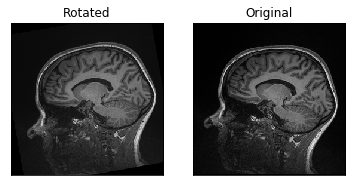

In [7]:
test = ndimage.rotate(back_fft[100],10, reshape = False)

plt.subplot(121), plt.imshow(test, cmap='gray')
plt.title('Rotated'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(back_fft[100], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

(Text(0.5,1,'Original'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

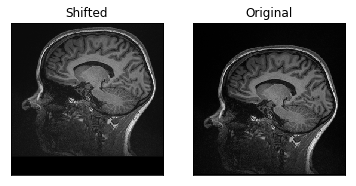

In [8]:
test2 = ndimage.shift(back_fft[100],[-30,0], mode='constant', cval=0)
plt.subplot(121), plt.imshow(test2, cmap='gray')
plt.title('Shifted'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(back_fft[100], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

In [106]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9
